In [56]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from tslearn.metrics import dtw
from tslearn.utils import to_time_series
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [57]:
folder_name = 'cluster_timeseries/'

collected_data = ["2020-2024"]

#dtw_knn_2 -> datasetnya lebih besar
# https://code.earthengine.google.com/52607160b523092795f576172fb238b3

labeled_df = pd.read_csv(folder_name + "label_pandanwangi_ids.csv").drop([".geo", "system:index"], axis=1)
warungkondang_df = pd.read_csv(folder_name + "warungkondang_2020_2024.csv").drop("system:index", axis=1)
cluster_geo = warungkondang_df[['cluster_id', '.geo']]
warungkondang_df = warungkondang_df.drop(".geo", axis=1)

In [58]:
labeled_df.head()

,cluster_id,label
0,2021138719,pandanwangi
1,590686206,pandanwangi
2,-579235901,pandanwangi
3,-83207285,pandanwangi
4,34695210,pandanwangi


In [59]:
cluster_geo.head()

,cluster_id,.geo
0,2021138719,"{""geodesic"":false,""type"":""MultiPolygon"",""coord..."
1,590686206,"{""geodesic"":false,""type"":""MultiPolygon"",""coord..."
2,-579235901,"{""geodesic"":false,""type"":""Polygon"",""coordinate..."
3,-83207285,"{""geodesic"":false,""type"":""Polygon"",""coordinate..."
4,34695210,"{""geodesic"":false,""type"":""MultiPolygon"",""coord..."


In [60]:
columns = warungkondang_df.columns.tolist()
renamed_columns = []

for col in columns:
    colname = ""
    if "T48MYT" in col:
        colname = col.split("_")[3][:8]
    elif "LC08" in col:
        colname = col.split("_")[5]
    elif "LE07" in col:
        colname = col.split("_")[3]
    renamed_columns.append(colname)

renamed_columns = renamed_columns[:-1]

old_new_col = dict(zip(columns, renamed_columns))
# print(old_new_col)

In [61]:
warungkondang_df = warungkondang_df.rename(columns=old_new_col)
# print(warungkondang_df)
# menghapus kolom yg namanya duplikat
warungkondang_df = warungkondang_df.loc[:, ~warungkondang_df.columns.duplicated(keep='first')]

# mengurutkan kolom berdasarkan urutan tanggalnya
warungkondang_df = warungkondang_df.reindex(sorted(warungkondang_df.columns), axis=1)

warungkondang_df = warungkondang_df.ffill(axis=1)
warungkondang_df = warungkondang_df.bfill(axis=1)

In [62]:
labeled_df.shape

(75, 2)

In [63]:
warungkondang_labeled = warungkondang_df[warungkondang_df['cluster_id'].isin(labeled_df['cluster_id'])]
warungkondang_not_labeled = warungkondang_df[~warungkondang_df['cluster_id'].isin(labeled_df['cluster_id'])]

In [64]:
print("labeled data: " + str(warungkondang_labeled.shape))
print("non-labeled data: " + str(warungkondang_not_labeled.shape))

labeled data: (75, 410)
non-labeled data: (187, 410)


In [65]:
warungkondang_labeled = pd.merge(warungkondang_labeled, labeled_df, on='cluster_id', how='left')

X_wk = warungkondang_labeled.iloc[:, :-2]
y_wk = warungkondang_labeled['label']
print(X_wk.shape)

X_train, X_test, y_train, y_test = train_test_split(X_wk, y_wk, test_size=0.33, random_state=42, stratify=y_wk)

(75, 409)


In [66]:
# buat model KNN

def dtw_score(x, y):
    x_formatted = to_time_series(x)
    y_formatted = to_time_series(y)
    dtw_score = dtw(x_formatted, y_formatted)
    itakura_dtw = dtw(x_formatted, y_formatted, global_constraint="itakura", itakura_max_slope=2)
    sakoe_chiba_dtw = dtw(x_formatted, y_formatted, global_constraint="sakoe_chiba", sakoe_chiba_radius=2)
    return sakoe_chiba_dtw
    
    

knn_1 = KNeighborsClassifier(n_neighbors = 5, metric=dtw_score)
knn_1.fit(X_train, y_train)

y_pred = knn_1.predict(X_test)

In [67]:
def evaluate(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_test), 
                yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


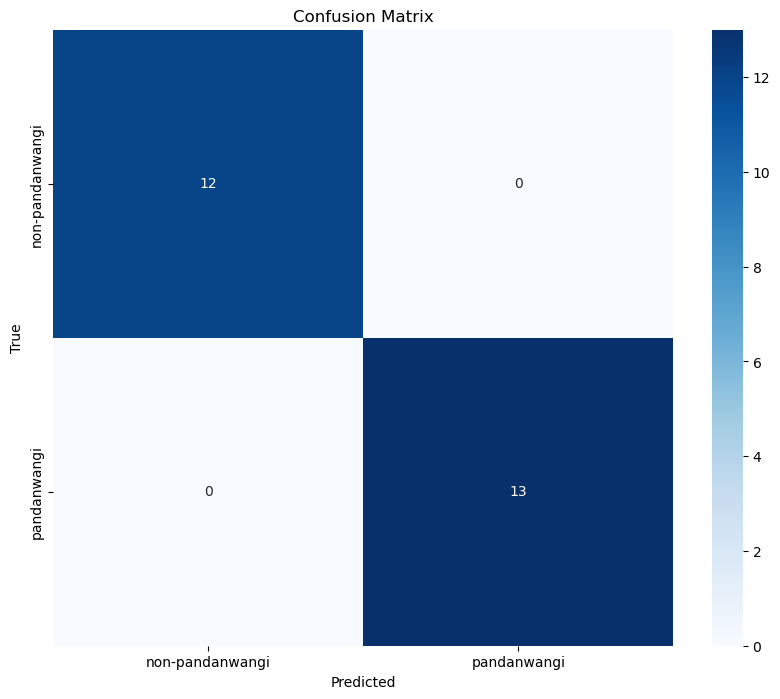

In [68]:
evaluate(y_test, y_pred)

In [69]:
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}


# print(scoring)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

stratified_cv_scores = cross_val_score(knn_1, X_wk, y_wk, cv=skf, scoring='accuracy')

print("\nStratified k-fold results:")
for i, score in enumerate(stratified_cv_scores):
    print(f"Fold {i+1}: {score:.4f}")

print(f"\nAverage accuracy (stratified): {np.mean(stratified_cv_scores):.4f}")
print(f"Standard deviation (stratified): {np.std(stratified_cv_scores):.4f}")


Stratified k-fold results:
Fold 1: 1.0000
Fold 2: 1.0000
Fold 3: 1.0000
Fold 4: 1.0000
Fold 5: 1.0000
Fold 6: 1.0000
Fold 7: 1.0000
Fold 8: 1.0000
Fold 9: 1.0000
Fold 10: 1.0000

Average accuracy (stratified): 1.0000
Standard deviation (stratified): 0.0000


In [70]:
#with larger dataset
final_model = KNeighborsClassifier(n_neighbors=5, metric=dtw_score)
final_model.fit(X_wk, y_wk)

pickle.dump(final_model, open(folder_name + 'saved_models/' + 'ts_classification.pkl', 'wb'))
pickle.dump(X_wk.columns, open(folder_name + 'saved_models/' + 'model_features.pkl', 'wb'))

predict_all = final_model.predict(warungkondang_not_labeled.iloc[:, :-1])
# print(predict_all)

['pandanwangi' 'pandanwangi' 'pandanwangi' 'pandanwangi' 'pandanwangi'
 'pandanwangi' 'pandanwangi' 'pandanwangi' 'pandanwangi' 'pandanwangi'
 'pandanwangi' 'pandanwangi' 'pandanwangi' 'non-pandanwangi' 'pandanwangi'
 'pandanwangi' 'pandanwangi' 'pandanwangi' 'pandanwangi' 'pandanwangi'
 'pandanwangi' 'pandanwangi' 'pandanwangi' 'non-pandanwangi'
 'non-pandanwangi' 'non-pandanwangi' 'non-pandanwangi' 'pandanwangi'
 'non-pandanwangi' 'non-pandanwangi' 'non-pandanwangi' 'pandanwangi'
 'pandanwangi' 'non-pandanwangi' 'non-pandanwangi' 'pandanwangi'
 'pandanwangi' 'non-pandanwangi' 'non-pandanwangi' 'non-pandanwangi'
 'non-pandanwangi' 'non-pandanwangi' 'non-pandanwangi' 'non-pandanwangi'
 'non-pandanwangi' 'non-pandanwangi' 'non-pandanwangi' 'pandanwangi'
 'pandanwangi' 'non-pandanwangi' 'non-pandanwangi' 'non-pandanwangi'
 'non-pandanwangi' 'non-pandanwangi' 'non-pandanwangi' 'non-pandanwangi'
 'non-pandanwangi' 'non-pandanwangi' 'non-pandanwangi' 'non-pandanwangi'
 'non-pandanwangi' 'no

In [71]:
unlabeled_df = warungkondang_not_labeled.copy()
unlabeled_df['label'] = predict_all
predicted_df = unlabeled_df.copy()

model_df = warungkondang_labeled.copy()

In [72]:
final_df = pd.concat([model_df, predicted_df], axis=0)
final_df.shape

(262, 411)

In [73]:
output_filename = "warungkondang" + ".csv"
output_folder = 'classification_result/'

final_df.to_csv(folder_name + output_folder + output_filename)